# Tomato Leaf Classification

##### This project aims to classify different categories of the tomato plant leaves based on some of the diseases they might get, the classifications include:
##### 1- Bactrial Spots
##### 2- Early Blight
##### 3- Healthy
##### 4- Late Blight
##### 5- Leaf Mold
##### 6- Septoria Leaf Spot
##### 7- Spider Mites 2 Spotted Spider Mites
##### 8- Target Spot
##### 9- Mosaic Virus
##### 10- Yellow Leaf Curl Virus

In [83]:
import os
import shutil
from zipfile import ZipFile

import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Download the data

The code block below will download the data if it weren't already in the device

In [84]:
if os.path.exists('tomato-diseases-dataset-csvimages.zip')==False:
    !kaggle datasets download -d ammarnassanalhajali/tomato-diseases-dataset-csvimages

#### Extract the data

In [85]:
if os.path.exists('train.csv')==False:
    with ZipFile('tomato-diseases-dataset-csvimages.zip', 'r') as zf:
        zf.extractall()

#### Preprocessing the data

This step is mostly irrelevant because we will be dealing with images data, and the only columns we will be using from the csv file are "img", "label_text" and "label" columns

In [86]:
train = pd.read_csv('train.csv')
train.rename(columns={"Unnamed: 0": "id"}, inplace=True)
train.head()

,id,path,img,label_text,label
0,0,../input/plantvillage-dataset/color/Tomato___L...,781e93a9-2059-42de-8075-658033a6abf7___RS_Late...,Tomato___Late_blight,2
1,1,../input/plantvillage-dataset/color/Tomato___L...,283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 L...,Tomato___Late_blight,2
2,2,../input/plantvillage-dataset/color/Tomato___L...,0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 L...,Tomato___Late_blight,2
3,3,../input/plantvillage-dataset/color/Tomato___L...,078a999d-6e6f-427e-a1e6-80b4d2df2bae___GHLB2 L...,Tomato___Late_blight,2
4,4,../input/plantvillage-dataset/color/Tomato___L...,3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late...,Tomato___Late_blight,2


#### Seperating the Tomatos
We have the folder Tomato_images, this folder contains images of leaves however the data is not seperated like the "Cat Dog" example so we will have to seperate it before we could start with building our model

The code blocks below will create directories depending on the label and automaticlly store each image in its label directory

In [87]:
# create the folders
labels = train['label_text']
for label in labels:
    os.makedirs(f'new_images/{label}', exist_ok=True)

In [88]:
# iterate rows and copy images
for _, row in train.iterrows():
    label = row['label_text']
    path = os.path.join('Tomato_images/Tomato_images',row['img'])
    img_name = row['img']
    new_path = os.path.join(f'new_images/{label}', img_name)
    try:
        shutil.copy(path, new_path)
    except Exception as e:
        if str(e) in '[Errno 2] No such file or directory:':
            continue

In [89]:
#shutil.rmtree('\Tomato_images\Tomato_images', ignore_errors=False, onerror=None)

In [90]:
#! ls -d */ 'Tomato_images/Tomato_images'

In [91]:
# for i in set(labels):
#   shutil.rmtree(f'new_images\{i}')

#### Generate a Dataset


Here we will be seperating the data by trianing set and validation set, we will use this image_size because it is the most compatiable with the next CNN function

In [92]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "new_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 18160 files belonging to 10 classes.
Using 14528 files for training.
Using 3632 files for validation.


#### Visualize the data
Here are the first 9 images in the training dataset.

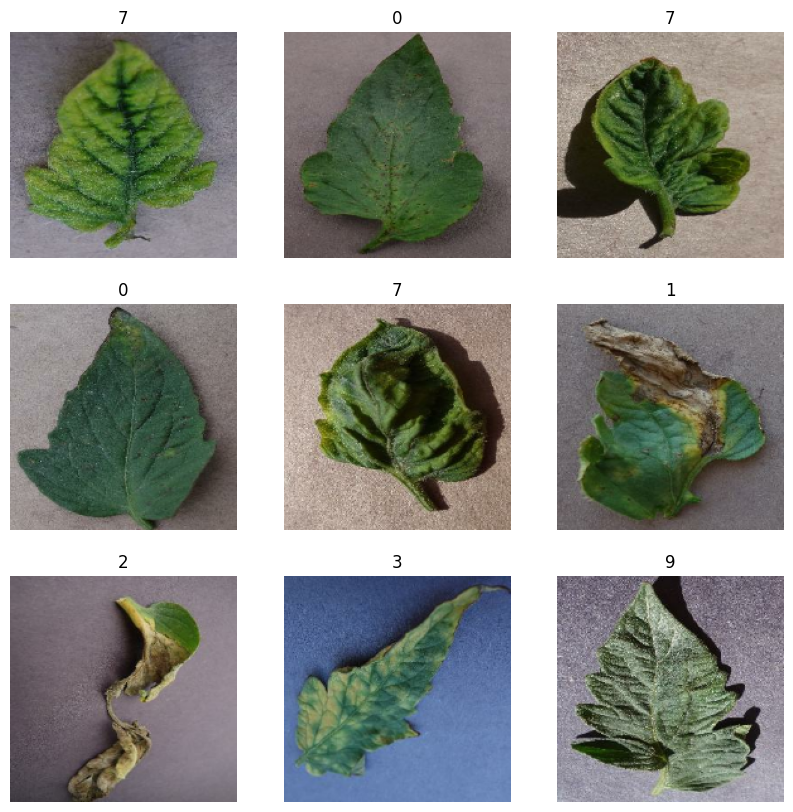

In [93]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### Using image data augmentation
When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting. This might not be that effective on our dataset since we have a lot of images but we will do it anyway just to maximize the accuracy of the Nueral Network.

In [94]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first few images in the dataset:



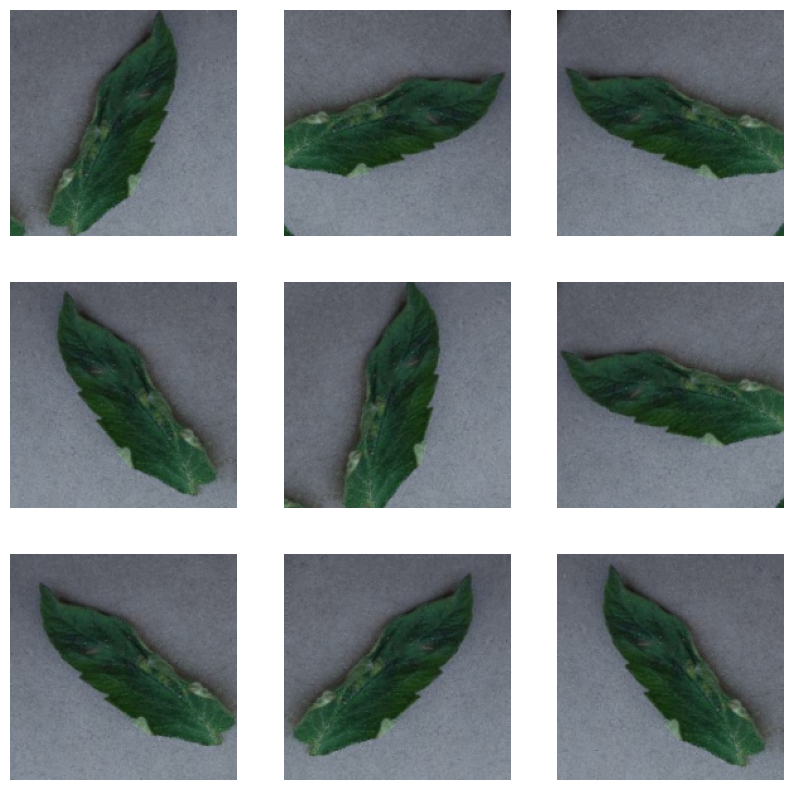

In [95]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


#### Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

#### Preprocess the data

Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [96]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

#### Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

In [106]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation=None)(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)

#### Train the model

The model training step has taken from us 12 hours just to train a single epoch, for this reason I've decided to use only 2000 images instead of the 18K images

In [107]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("models/save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="sum_over_batch_size"),
    metrics=['accuracy'],
)

In [108]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
114/114 [==============================] - 179s 1s/step - loss: 0.6358 - accuracy: 0.7879 - val_loss: 2.3280 - val_accuracy: 0.1030
Epoch 2/5
114/114 [==============================] - 171s 1s/step - loss: 0.2760 - accuracy: 0.9080 - val_loss: 2.7500 - val_accuracy: 0.1030
Epoch 3/5
114/114 [==============================] - 171s 1s/step - loss: 0.1738 - accuracy: 0.9418 - val_loss: 3.7286 - val_accuracy: 0.1030
Epoch 4/5
114/114 [==============================] - 172s 1s/step - loss: 0.1276 - accuracy: 0.9575 - val_loss: 4.6948 - val_accuracy: 0.1030
Epoch 5/5
114/114 [==============================] - 173s 2s/step - loss: 0.1148 - accuracy: 0.9615 - val_loss: 4.0263 - val_accuracy: 0.3901


#### Run inference on new data

Let's try our model on a random picture.

In [154]:
train.iloc[1]

id                                                            1
path          ../input/plantvillage-dataset/color/Tomato___L...
img           283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 L...
label_text                                 Tomato___Late_blight
label                                                         2
Name: 1, dtype: object

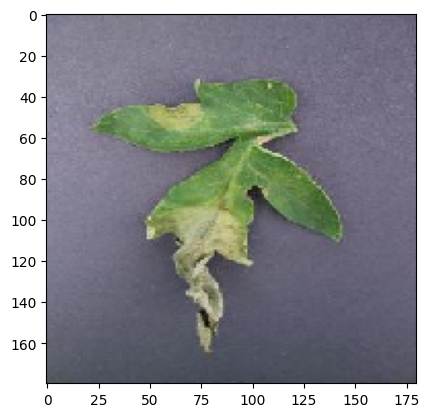

In [155]:
img = keras.utils.load_img(f'Tomato_images/Tomato_images//{train.iloc[1].img}', target_size=image_size)
plt.imshow(img)

model = keras.models.load_model('models/save_at_5.keras')

img_array = keras.utils.img_to_array(img)
img_array = keras.backend.expand_dims(img_array, 0)  # Create batch axis

In [156]:
train[['label', 'label_text']].drop_duplicates()

,label,label_text
0,2,Tomato___Late_blight
1909,9,Tomato___healthy
3500,1,Tomato___Early_blight
4500,4,Tomato___Septoria_leaf_spot
6271,7,Tomato___Tomato_Yellow_Leaf_Curl_Virus
11628,0,Tomato___Bacterial_spot
13755,6,Tomato___Target_Spot
15159,8,Tomato___Tomato_mosaic_virus
15532,3,Tomato___Leaf_Mold
16484,5,Tomato___Spider_mites Two-spotted_spider_mite


In [153]:
predictions = model.predict(img_array)
score = float(keras.backend.relu(predictions[0][0]))
print('This image belongs to the class:',np.argmax(predictions, axis=1))
#score

1/1 [==============================] - 0s 73ms/step
This image belongs to the class: [2]


#### Increasing the model's accuracy

The model has predicted the picture correctly, this picutre belongs to the 2nd class which is called Late Blight.

There are many ways we can increase this model's accuracy, one of the ways is to increase the number of epochs.

Since I had little time to build the model I've used only 5 epochs in this project, however in a better scenario I'd have used about 50 epochs for this dataset.

Another thing that could've imporoved the model's performance would have been to do more data augmentation techniquese.

This could be done by Color space transformations whcich is to randomly change RGB color channels, contrast, and brightness.